# Fundamentals of Social Data Science 
## Week 3 Day 2. Lab. Text Processing 

In this lab I have generated some methods that will allow you to download posts from Reddit. It accepts a list of subreddits of arbitrary length, which are each processed independently and stored in a single `results` dictionary. The keys of the dictionary are the subreddits. Underneath each subreddit is a dictionary of sub-specific result objects, like "vectorizer" and "top terms".

Please read through the code. You will need to add your username. The code is intentionally broken so you will need to add that before running this. Other than that you should not need to make any modifications to the cell with the `RedditScraper` class. 

In the cell below is some code to run these methods. At the top are some parameters that you should set. These are typically written in ALL CAPS. You should read the code to understand what they do. 

# Exercises: 
    
0. **Explore subreddits**. The below code uses 'ukpolitics', 'unitedkingdom', and 'uknews'. These were loosely motivated by an interest in whether uknews has become a reactionary subreddit with generally conservative opinions. By comparing it to the other two (which other work has suggested are generally quite similar), we might get a sense of this from the top keywords. Try some other subs related to a topic where you suspect there will be some interesting distinctions. Motivate the distinctions. If you aren't sure about the subs, query an LLM (they are typically trained on a _lot_ of Reddit data and will know good subs). So instead of trying for /r/men and /r/women, if you ask about subs for gender-based interests, it might suggest /r/TwoXChromosomes and /r/MensRights as interesting distinctions. 
1. **Understand the results data structure**. The `results` object returns the top 5 terms. How would you access more than 5 terms? Expand the results to see 10. Consider what way is more general and flexible. How might you change the code so that there is a `TOP_N = 10` which is then passed through the code so that the results dictionary contains ten terms in the "top_terms" DataFrame rather than hard coding it in the method below?
2. **Store results**. Every time we run the code we query Reddit again. How can we store our data so that it is cached for another round? There are many approaches to this and among your group you may discover everything from 'just save the json' to 'DataFrame and then export to feather' to some who would ambitiously use MongoDB. Given this is a simple exercise for now, keep this step simple as you need it to be while still usable enough if you want to add more data.
3. **Plot keywords over time**. Expand your results to anywhere from 250 upwards (I would here cap at 500 max and think that the api might only return last 1000 but untested). Determine the top keywords using TFIDF. Then plot the frequency of these keywords over this time period for these results.   
4. **Table the most common URLs for stories**. Triangulate these plots with a table summarising the top news outlets for this sub in this time period. Notice the starter code to process this from the posts data that has been stored in a large `submissions` dictionary. Note, this code does not turn all the `json` into a DataFrame, but extracts only the URL column and processes that. It also uses a _regular expression_ to separate out the top level domain, which may or may not be the most robust.  
5. **Write a summary**. Solely for reflection at this point, write some intuitions that you discover with this exploration. 

## Caveats for the exercise: 
- Reddit might severely limit the number of posts you download using this scraper even with your name appropriately in the username, so be judicious with your exploration (hence exercise 2 _first_). 
- While you might not have extensive experience with Reddit, I can be confident that there are subreddits on most imaginable topics that can be found with little challenge. However, these subs will have vastly different numbers of subscribers and activity, so bear that in mind with any interpretation when tempted to generalise what is found _beyond_ Reddit (i.e. generalising from /r/republicans to Republicans in the US). 
- You may be tempted out of curiosity to expand your data collection. You will find that this will lead to a trade off if you do not further process your data. If you have 1000 rows for headlines and 3000 for words, that's a big matrix that has to be multiplied by vectors. At some point the size of the matrix will be unnecessary as well as slow. You may need to consider different parameters for `MIN_DOC_FREQ` to get a balance between a big matrix and a meaningful one. 
- These results have not been cleared for publication with CUREC, but only for use within classroom and for illustrative purposes. Please do not upload raw reddit data to your own GitHub archive nor seek to publish these results.  (Notice that I have pre-emtively edited the .gitignore to include a `data/` folder where you can store results without uploading them). Seek advice from research.fac@oii.ox.ac.uk for use for a comparable project should you wish to publish this work. If you wish to produce a blog post or other informal analysis, this should be presented in such a way that it is not misconstrued that the University has endorsed this work for publication. 

# Where we are headed with this exercise 

### Today: 
Collect reddit data, make it robust and explore TF-IDF results. 

### Week 3 Day 3. Friday: 
We use contine the use of the TF-IDF matrix and introduce cosine distance. We show how to plot it using t-SNE. This might sound abstract but the results will be fascinating as we see words plotted in coherent clusters that seem to reveal inductive patterns. 

Worksheets will be uploaded to this repo. 

### Week 4 Day 1. Monday: 
We will use two simple forms of classification, k-means and Naive Bayes Clustering. You might also be familiar with LDA or 'topic modelling'. We will not cover this as the technique deserves some care to understand its internals even if it is easy to run out of the box. But it is not far as an extension from where we end up. 

In the lab we will then compare classification results to results from the t-SNE and exploration of distance from Friday. 

### Week 4 Day 2. Wednesday: 
We will introduce the `networkx` and `community` package and show how to both construct a network from threaded comments and users of these comments. This will involve two types of graphs: DAGs and Bipartite graphs. 

In the lab you will have code that shows how to do this with the Reddit data in general. You will have to apply this to your specific case. 

### Week 4 Day 3. Friday: 
In the walkthrough we will see how to create 'embeddings' as abstractions even further than t-SNE but as a next-step up from cosine distance. In fact we will see how you can use cosine distance on embeddings which allows you to do these same steps not with words, but with entire sentences or whole paragraphs. We feature this on Friday and assume that your presentations will not need to use embeddings. 

In the afternoon you we will have the second set of group presentations: 
- Take a current event or coherent topic that could be collected from reddit data using the requests API (or more abstract packages such as `praw`, but not entire archive dumps like PushShift, only a limited subset). 
- Look at three or more subreddits who might speak to that topic. Determine which two subs are the most similar and why? Be sure to consider not only common word use. You may define similarity in creative ways so long as they can result in calculable differences without use of ML models, external APIs, or mass labelling of data. If you can download a lexicon, you are welcome to use scoring.
- Motivate this topic deductively. Where possible try to draw upon any existing literature on the topic and not simply abductively from current events. Consider DIKW: Find ways to produce transferable _knowledge_ rather than merely _information_ from _data_. 

In [1]:
import requests
import time
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import nltk
import json
import os
nltk.download('stopwords')

class RedditScraper:
    def __init__(self, user_agent):
        """
        Initialize the scraper with a user agent string.
        Example user agent: "SDS_textanalysis/1.0 (by /u/your_username)"
        """
        self.headers = {'User-Agent': user_agent}
        self.base_url = "https://api.reddit.com"
        
    def get_subreddit_posts(self, subreddit, limit=100):
        """
        Collect posts from a subreddit with proper pagination and rate limiting.
        """
        posts = []
        after = None
        
        while len(posts) < limit:
            url = f"{self.base_url}/r/{subreddit}/new"
            params = {
                'limit': min(100, limit - len(posts)),
                'after': after
            }
            
            response = requests.get(url, headers=self.headers, params=params)
            
            if response.status_code != 200:
                print(f"Error accessing r/{subreddit}: {response.status_code}")
                break
                
            data = response.json()
            new_posts = data['data']['children']
            if not new_posts:
                break
                
            posts.extend([post['data'] for post in new_posts])
            after = data['data']['after']
            
            if not after:
                break
                
            time.sleep(2)
            
        return posts[:limit]


# Save submissions to cache
def save_submissions_to_cache(submissions, filename):
    with open(filename, 'w') as f:
        json.dump(submissions, f)
    print("Submissions saved to cache.")

# Load submissions from cache
def load_submissions_from_cache(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            cached_submissions = json.load(f)
        print("Loaded submissions from cache.")
        return cached_submissions
    return None


def preprocess_text(text):
    """
    Clean and normalize text.
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def analyze_vocabulary(texts, min_freq=2):
    """
    Analyze vocabulary distribution in a corpus.
    Returns word frequencies and vocabulary statistics.
    """
    # Tokenize all texts
    words = ' '.join(texts).split()
    
    # Count word frequencies
    word_freq = Counter(words)
    
    # Calculate vocabulary statistics
    total_words = len(words)
    unique_words = len(word_freq)
    
    # Create frequency distribution DataFrame
    freq_df = pd.DataFrame(list(word_freq.items()), columns=['word', 'frequency'])
    freq_df['percentage'] = freq_df['frequency'] / total_words * 100
    freq_df = freq_df.sort_values('frequency', ascending=False)
    
    # Calculate cumulative coverage
    freq_df['cumulative_percentage'] = freq_df['percentage'].cumsum()
    
    stats = {
        'total_words': total_words,
        'unique_words': unique_words,
        'words_min_freq': sum(1 for freq in word_freq.values() if freq >= min_freq),
        'coverage_top_1000': freq_df.iloc[:1000]['frequency'].sum() / total_words * 100 if len(freq_df) >= 1000 else 100
    }
    
    return freq_df, stats

def analyze_subreddit(posts, top_n, max_terms=1000, min_doc_freq=2):
    """
    Analyze a single subreddit's posts independently.
    """
    # Combine title and selftext
    texts = [
        preprocess_text(post.get('title', '')) + ' ' + 
        preprocess_text(post.get('selftext', ''))
        for post in posts
    ]
    
    # Analyze vocabulary first
    freq_df, vocab_stats = analyze_vocabulary(texts, min_freq=min_doc_freq)
    
    # Initialize TF-IDF vectorizer for this subreddit
    stop_words = list(set(stopwords.words('english')))
    vectorizer = TfidfVectorizer(
        stop_words=stop_words,
        max_features=max_terms,
        min_df=min_doc_freq
    )
    
    # Compute TF-IDF
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Get average TF-IDF scores
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top terms
    feature_names = vectorizer.get_feature_names_out()
    top_terms = pd.DataFrame({
        'term': feature_names,
        'score': mean_tfidf
    }).sort_values('score', ascending=False)
    
    return {
        'vocab_stats': vocab_stats,
        'freq_distribution': freq_df,
        'top_terms': top_terms.head(top_n),
        'vectorizer': vectorizer,
        'matrix_shape': tfidf_matrix.shape,
        'matrix_sparsity': 100 * (1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
    }




[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Example subreddits
subreddits = ['classicalmusic', 'violinist', 'lingling40hrs']

# Analysis parameters
MAX_TERMS = 1000
MIN_DOC_FREQ = 2
LIMIT = 100
USERNAME = 'Chris-Li' # Replace with your Reddit username
TOP_N = 10

# Define file path for cached results
CACHE_FILE = './data/reddit_submissions_cache.json'

# Initialize scraper
scraper = RedditScraper(
user_agent=f"SDS_textanalysis/1.0 (by /u/{USERNAME})"
)

# Load from cache or fetch new data
submissions = load_submissions_from_cache(CACHE_FILE)
if not submissions:
    submissions = {}
    for subreddit in subreddits:
        submissions[subreddit] = scraper.get_subreddit_posts(subreddit, limit=LIMIT)
    save_submissions_to_cache(submissions, CACHE_FILE)

# Analyze each subreddit independently
results = {}

for subreddit in subreddits:
    print(f"\nAnalyzing r/{subreddit}...")

    # Collect posts
    submissions[subreddit] = scraper.get_subreddit_posts(subreddit, limit=LIMIT)

    # Analyze subreddit
    results[subreddit] = analyze_subreddit(
        submissions[subreddit],
        top_n=TOP_N,
        max_terms=MAX_TERMS,   # Maximum number of terms to keep
        min_doc_freq=MIN_DOC_FREQ   # Term must appear in at least min_doc_freq documents
    )

    # Print results for this subreddit
    print(f"\nVocabulary Statistics for r/{subreddit}:")
    print(f"Total words: {results[subreddit]['vocab_stats']['total_words']}")
    print(f"Unique words: {results[subreddit]['vocab_stats']['unique_words']}")
    print(f"Words appearing ≥{MIN_DOC_FREQ} times: {results[subreddit]['vocab_stats']['words_min_freq']}")
    print(f"Coverage by top {MAX_TERMS} words: {results[subreddit]['vocab_stats']['coverage_top_1000']:.2f}%")
    print(f"Matrix shape: {results[subreddit]['matrix_shape']}")
    print(f"Matrix sparsity: {results[subreddit]['matrix_sparsity']:.2f}%")

    print(f"\nTop {TOP_N} terms by TF-IDF score:")
    print(results[subreddit]['top_terms'][['term', 'score']].to_string())

Submissions saved to cache.

Analyzing r/classicalmusic...

Vocabulary Statistics for r/classicalmusic:
Total words: 7528
Unique words: 2063
Words appearing ≥2 times: 746
Coverage by top 1000 words: 85.88%
Matrix shape: (100, 516)
Matrix sparsity: 96.25%

Top 10 terms by TF-IDF score:
          term     score
275      music  0.055482
313      piece  0.047421
314     pieces  0.040234
62   classical  0.037913
270   movement  0.037537
280        new  0.032334
312      piano  0.029380
238    looking  0.028341
289        one  0.027591
168  halloween  0.026458

Analyzing r/violinist...

Vocabulary Statistics for r/violinist:
Total words: 9268
Unique words: 1930
Words appearing ≥2 times: 836
Coverage by top 1000 words: 89.97%
Matrix shape: (100, 586)
Matrix sparsity: 95.53%

Top 10 terms by TF-IDF score:
        term     score
551   violin  0.068757
232       im  0.053943
319      new  0.041562
187      get  0.034299
482  strings  0.032687
336      one  0.030520
520     time  0.030262
369    

In [10]:
# Data Exploration: 
submissions['classicalmusic'][0] # Example post from the unitedkingdom subreddit

url_list = [post['url'] for post in submissions['classicalmusic']]
url_df = pd.DataFrame(url_list, columns=['url'])
url_df['domain'] = url_df['url'].str.extract(r'(https?://[^/]+)')

url_df['domain'].value_counts().head(10)

domain
https://www.reddit.com         55
https://youtu.be               15
https://www.youtube.com        10
https://i.redd.it               7
https://youtube.com             4
https://v.redd.it               3
https://open.spotify.com        1
https://m.youtube.com           1
https://www.screen-idle.com     1
https://www.nytimes.com         1
Name: count, dtype: int64

In [11]:
results['classicalmusic'].keys()

dict_keys(['vocab_stats', 'freq_distribution', 'top_terms', 'vectorizer', 'matrix_shape', 'matrix_sparsity'])

In [18]:
cache_data = submissions['classicalmusic'][0]
cache_key = list(cache_data.keys())

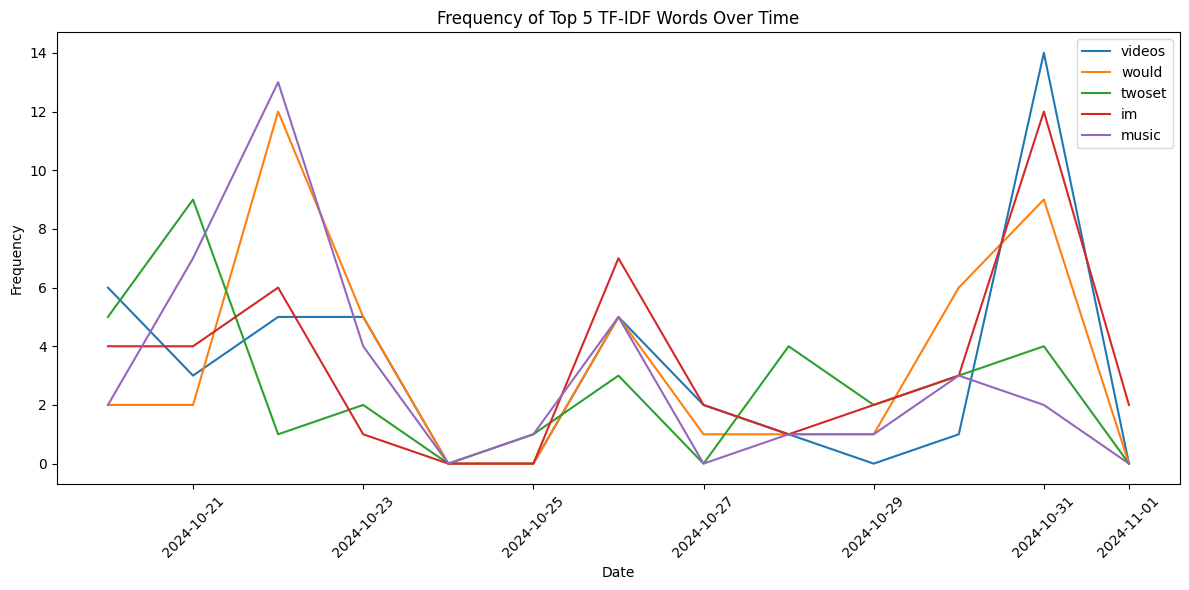

In [26]:
from datetime import datetime

# Organize posts by date
date_texts = {}
for post in submissions[subreddit]:
    # Convert timestamp to date
    date = datetime.utcfromtimestamp(post['created_utc']).date()
    text = preprocess_text(post.get('title', '') + ' ' + post.get('selftext', ''))
    
    # Aggregate texts for each date
    if date in date_texts:
        date_texts[date] += ' ' + text
    else:
        date_texts[date] = text

# Prepare texts for TF-IDF
dates, daily_texts = zip(*sorted(date_texts.items()))

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=MAX_TERMS, min_df=MIN_DOC_FREQ)
tfidf_matrix = vectorizer.fit_transform(daily_texts)
feature_names = vectorizer.get_feature_names_out()

# Find top keywords

# word_sums = tfidf_matrix.sum(axis=0).A1 
mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
top_indices = mean_tfidf.argsort()[-5:][::-1]  
top_keywords = [feature_names[i] for i in top_indices]


    
top_keywords_by_date = []
for date, text in date_texts.items():
    daily_counts = Counter(text.split())
    daily_frequencies = [daily_counts[word] for word in top_keywords]
    top_keywords_by_date.append(daily_frequencies)
    

import matplotlib.pyplot as plt

# Prepare DataFrame for plotting

df = pd.DataFrame(top_keywords_by_date, index=sorted(date_texts.keys()), columns=top_keywords)

# Plot each keyword's TF-IDF score over time
plt.figure(figsize=(12, 6))
for word in df.columns:
    plt.plot(df.index, df[word], label=word)

plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Frequency of Top 5 TF-IDF Words Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [29]:
from urllib.parse import urlparse
# Data Exploration: 
submissions['classicalmusic'][0] # Example post from the unitedkingdom subreddit

url_list = [post['url'] for post in submissions['classicalmusic']]
url_df = pd.DataFrame(url_list, columns=['url'])
url_df['domain'] = url_df['url'].str.extract(r'(https?://[^/]+)')

url_df['domain'].value_counts().head(10)

def get_top_domains(submissions, top_n=10):
    domain_counts = {}
    for subreddit, posts in submissions.items():
        # Extract URLs from each post
        url_list = [post['url'] for post in posts if 'url' in post]
        
        # Extract domain using the method from your example
        url_df = pd.DataFrame(url_list, columns=['url'])
        url_df['domain'] = url_df['url'].str.extract(r'(https?://[^/]+)')
        
        # Count domain occurrences
        domain_counter = Counter(url_df['domain'])
        common_domains = domain_counter.most_common(top_n)
        
        # Store the results in a DataFrame for this subreddit
        domain_counts[subreddit] = pd.DataFrame(common_domains, columns=['Domain', 'Frequency'])
    
    return domain_counts

# Step 2: Call the function and display the results
top_n = 10  # Adjust this to control how many top domains you want to see
domain_tables = get_top_domains(submissions, top_n=top_n)

for subreddit, table in domain_tables.items():
    print(f"\nTop {top_n} domains for r/{subreddit}:")
    display(table)

# Helper function to extract top-level domain from a URL
def extract_domain(url):
    if pd.isna(url) or not url:
        return None
    domain = urlparse(url).netloc
    # Extract top-level domain (e.g., bbc.com from www.bbc.com)
    return re.sub(r'www\.', '', domain)

# Step 1: Extract URLs and domains from submissions
def get_top_domains(submissions, top_n=10):
    domain_counts = {}
    for subreddit, posts in submissions.items():
        # Extract domains
        domains = [extract_domain(post.get('url')) for post in posts if post.get('url')]
        domains = [domain for domain in domains if domain]  # Filter out None values
        
        # Count domain frequency
        domain_counter = Counter(domains)
        common_domains = domain_counter.most_common(top_n)
        
        # Store results in a DataFrame
        domain_counts[subreddit] = pd.DataFrame(common_domains, columns=['Domain', 'Frequency'])
    
    return domain_counts

# Step 2: Get the most common domains for each subreddit
top_n = 2  # Adjust this to show more or fewer top domains
domain_tables = get_top_domains(submissions, top_n=top_n)

# Step 3: Display the tables
for subreddit, table in domain_tables.items():
    print(f"\nTop {top_n} domains for r/{subreddit}:")
    display(table)


Top 10 domains for r/classicalmusic:


,Domain,Frequency
0,https://www.reddit.com,55
1,https://youtu.be,15
2,https://www.youtube.com,10
3,https://i.redd.it,7
4,https://youtube.com,4
5,https://v.redd.it,3
6,https://open.spotify.com,1
7,https://m.youtube.com,1
8,https://www.screen-idle.com,1
9,https://www.nytimes.com,1



Top 10 domains for r/violinist:


,Domain,Frequency
0,https://www.reddit.com,73
1,https://i.redd.it,16
2,https://v.redd.it,9
3,https://www.imgur.com,1
4,https://theviolinchannel.com,1



Top 10 domains for r/lingling40hrs:


,Domain,Frequency
0,https://www.reddit.com,73
1,https://i.redd.it,23
2,https://v.redd.it,3
3,https://apnews.com,1



Top 12 domains for r/classicalmusic:


,Domain,Frequency
0,reddit.com,55
1,youtu.be,15
2,youtube.com,14
3,i.redd.it,7
4,v.redd.it,3
5,open.spotify.com,1
6,m.youtube.com,1
7,screen-idle.com,1
8,nytimes.com,1
9,algchat.com,1



Top 12 domains for r/violinist:


,Domain,Frequency
0,reddit.com,73
1,i.redd.it,16
2,v.redd.it,9
3,imgur.com,1
4,theviolinchannel.com,1



Top 12 domains for r/lingling40hrs:


,Domain,Frequency
0,reddit.com,73
1,i.redd.it,23
2,v.redd.it,3
3,apnews.com,1


# AI Declaration: 

Claude Sonnet 3.5 New produced much of the reddit code. I was surprised at how similar it was to my past code (knowing it was trained on GitHub I have to wonder). Several tweaks had to be made such as removing a main() function, altering the results object, altering some NLTK packages, adding the submissions dictionary and the submissions dictionary code. I kept in the `preprocess_text()` function as is, but you are encouraged to consider alternative forms of pre-processing from the walkthrough including the use of standard tokenizers, lemmatisation, and stop-words. It also used anodyne programming subreddits which I changed and I reduced the limit to 50 which is just enough to get two queries illustrating that you can get N queries through this approach. 

The URL code was written in VS code with co-pilot. Notably the autocomplete did an excellent job of anticipating steps with minimal prompting. 